In [1]:
import joblib
import pandas as pd

import pyLDAvis
import pyLDAvis.sklearn

import matplotlib.pyplot as plt
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import HoverTool, ColumnDataSource

import warnings
warnings.simplefilter('ignore')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

%matplotlib inline
output_notebook()

tweets = pd.read_csv('../tweets/tweets_clean.csv',
                     header=0,
                     parse_dates=['date'])
tweets.dropna(subset=['lemmas'], inplace=True)
tweets.reset_index(drop=True, inplace=True)

doc_topics = pd.read_csv('../results_csv/topics_per_doc_LDA.csv',
                         header=0)

tweets['topic'] = doc_topics['dominant_topic']

# Load vectorizer
with open('../topic_modeling_objects/sklearn_vect.joblib', 'rb') as f:
    cv = joblib.load(f)

# Load term frequency matrix
with open('../topic_modeling_objects/sklearn_CV.joblib', 'rb') as f:
    tf = joblib.load(f)

# Load feature names
with open('../topic_modeling_objects/sklearn_feature_names.joblib', 'rb') as f:
    tf_names = joblib.load(f)

# Load fitted LDA model
with open('../topic_modeling_objects/sklearn_LDA_model.joblib', 'rb') as f:
    lda_model = joblib.load(f)
    
lda_W = lda_model.transform(tf)

Loading BokehJS ...

In [2]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model, tf, cv, mds='tsne')
panel

PreparedData(topic_coordinates=                x           y  topics  cluster      Freq
topic                                                   
0      253.440155 -259.333771       1        1  8.444904
3        2.297387  144.774796       2        1  7.212025
1     -215.125305  -34.022278       3        1  7.040824
11    -516.783020   34.917622       4        1  6.768757
14    -298.946960  287.513000       5        1  6.756138
10     520.628540  189.543839       6        1  6.636613
7      554.071106 -132.695084       7        1  6.616233
4      258.421692  358.644989       8        1  6.611556
12     129.167648 -559.137146       9        1  6.496154
2      -35.757404  471.104279      10        1  6.451448
8     -172.249268 -482.011353      11        1  6.387627
9      469.898346 -472.802063      12        1  6.352640
13    -407.402740 -289.207611      13        1  6.232887
5      -12.746014 -211.288864      14        1  6.173315
6      246.108582   21.152027      15        1  5.818880, topic_info=     Category          Freq                          Term         Total  \
term                                                                      
2244  Default  31068.000000                         trump  31068.000000   
1497  Default   8474.000000                         obama   8474.000000   
981   Default   5623.000000                       hillary   5623.000000   
1458  Default   5495.000000                           new   5495.000000   
398   Default   8004.000000                       clinton   8004.000000   
1308  Default   6136.000000                          make   6136.000000   
906   Default   4950.000000                          good   4950.000000   
1753  Default   4843.000000               realdonaldtrump   4843.000000   
2311  Default   4669.000000                          vote   4669.000000   
1197  Default   4455.000000                          know   4455.000000   
228   Default   3958.000000                         black   3958.000000   
77    Default   4175.000000                       america   4175.000000   
1659  Default   3924.000000                     president   3924.000000   
538   Default   4039.000000                           day   4039.000000   
2325  Default   4401.000000                          want   4401.000000   
2122  Default   3950.000000                          take   3950.000000   
79    Default   4033.000000                      american   4033.000000   
2132  Default   3921.000000                          tcot   3921.000000   
2173  Default   3833.000000                         think   3833.000000   
1291  Default   3585.000000                          love   3585.000000   
1909  Default   3760.000000                           see   3760.000000   
2383  Default   3569.000000                         woman   3569.000000   
1317  Default   3546.000000                           man   3546.000000   
305   Default   3573.000000                          call   3573.000000   
2190  Default   4357.000000                          time   4357.000000   
1447  Default   3417.000000                          need   3417.000000   
1831  Default   3468.000000                         right   3468.000000   
982   Default   3058.000000                hillaryclinton   3058.000000   
685   Default   3136.000000                      election   3136.000000   
1455  Default   2935.000000                         never   2935.000000   
...       ...           ...                           ...           ...   
1216  Topic15   1451.847607                           law   1452.779083   
1221  Topic15   1108.454390                          lead   1109.385866   
1211  Topic15   1066.238869                          late   1067.170345   
805   Topic15   1039.086115                          fire   1040.017591   
971   Topic15   1011.959000                          hear   1012.890476   
1863  Topic15    971.384924                       russian    972.316400   
500   Topic15    924.079401                          cruz    92

In [3]:
topics_per_month = tweets.groupby([tweets.date.dt.year, tweets.date.dt.month, tweets.topic]).size().to_frame('counts')
topics_per_month.index.rename(['year', 'month'], level=[0, 1], inplace=True)

topics_per_month = topics_per_month.unstack(level=2, fill_value=0)

# # Collapse index back into a single date
topics_per_month.columns = topics_per_month.columns.droplevel(0)
topics_per_month.reset_index(inplace=True)
topics_per_month['date'] = pd.to_datetime(dict(year=topics_per_month.year,
                                               month=topics_per_month.month,
                                               day=[1] * len(topics_per_month)))
topics_per_month.drop(['year', 'month'], axis=1, inplace=True)
topics_per_month.columns = topics_per_month.columns.values.astype('str')

In [4]:
def monthly_topics(tweets_df):
    topics = [str(i) for i in range(15)]

    palette = ['#E53935', '#0288D1', '#8E24AA', '#00796B', '#689F38',
               '#D81B60', '#5E35B1', '#AFB42B', '#FBC02D', '#90A4AE',
               '#F57C00', '#1976D2', '#3949AB', '#0097A7', '#8D6E63']

    src = ColumnDataSource(tweets_df.to_dict('list'))

    p = figure(width=1200, height=800,
               x_axis_type='datetime',
               x_axis_label='Date',
               y_axis_label='Number of tweets',
               title='Tweets per month')

    renderers = p.vbar_stack(topics, x='date', color=palette,
                             width=3.6e8 * 5,
                             legend=["Topic " + x for x in topics],
                             source=src)

    legend = p.legend[0]
    p.legend[0].plot = None
    p.add_layout(legend, 'right')

    for r in renderers:
        topic = r.name
        hover = HoverTool(tooltips=[('Date', '@date{%B-%Y}'),
                                    ('Topic {}'.format(topic), '@$name')],
                          formatters={'date': 'datetime'},
                          mode='mouse',
                          renderers=[r])
        p.add_tools(hover)

    p.xgrid.grid_line_color = None

    return p

In [5]:
topics_plot = monthly_topics(topics_per_month)
show(topics_plot)

In [6]:
monthly_props = topics_per_month.drop('date', axis=1).apply(lambda x: 100. * x / x.sum(), axis=1)
monthly_props['date'] = topics_per_month['date']

In [7]:
topics_prop_plot = monthly_topics(monthly_props)
show(topics_prop_plot)

In [8]:
topics_per_month.set_index('date', inplace=True)
monthly_props.set_index('date', inplace=True)

In [9]:
def bar_suplots(df, props=False):
    if props:
        ylim = (0, 100)
    else:
        ylim = (0, 5500)

    axes = df.plot(kind='bar', use_index=True,
                   subplots=True, sharex=True, layout=(15, 1),
                   figsize=(16, 32), legend=False, ylim=ylim,
                   color=['#E53935', '#0288D1', '#8E24AA', '#00796B', '#689F38',
                          '#D81B60', '#5E35B1', '#AFB42B', '#FBC02D', '#90A4AE',
                          '#F57C00', '#1976D2', '#3949AB', '#0097A7', '#8D6E63'])

    for i, ax in enumerate(axes.reshape(-1)):
        ax.set_title('Topic' + str(i), fontsize=14)
        ax.set_xticklabels([date.strftime('%B-%Y') if i % 3 == 0 else '' for i, date in enumerate(topics_per_month.index)],
                           rotation=45, fontsize=12)

    plt.tight_layout()
    plt.show()

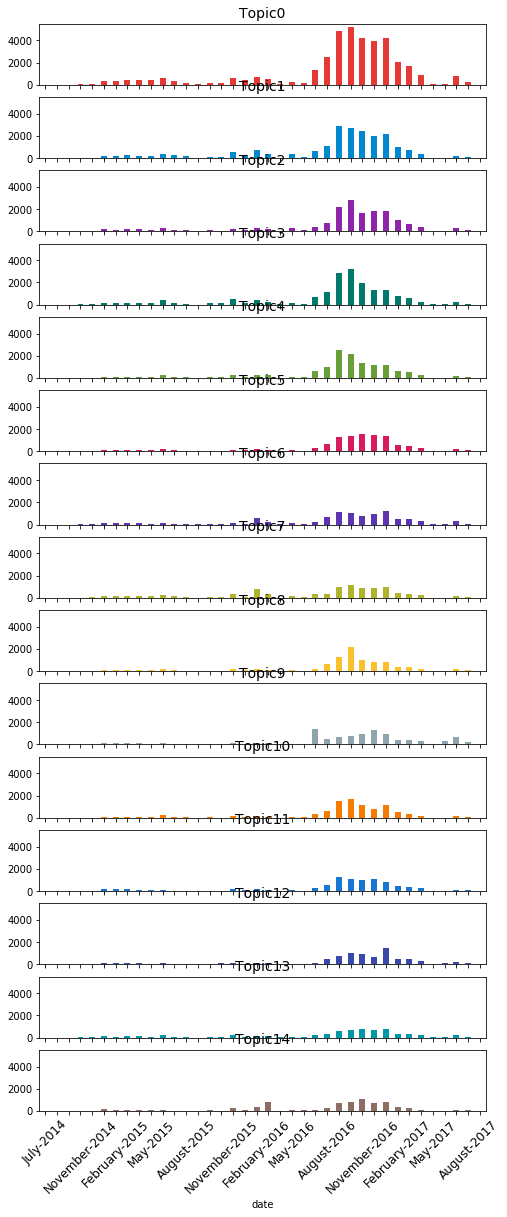

In [10]:
bar_suplots(topics_per_month)

In [ ]:
bar_suplots(monthly_props, props=True)

In [8]:
topics_daily = tweets.groupby([tweets.date.dt.date,
                               tweets.topic]).size().to_frame().unstack(level=1, fill_value=0)
topics_daily.columns = topics_daily.columns.droplevel(0)
topics_daily.columns = topics_daily.columns.values.astype('str')

topics_daily['sum'] = topics_daily.sum(axis=1)
topics_daily = topics_daily[topics_daily['sum'] >= 100]
topics_daily.drop('sum', axis=1, inplace=True)

topics_daily = topics_daily.apply(lambda x: x / x.sum(), axis=1)

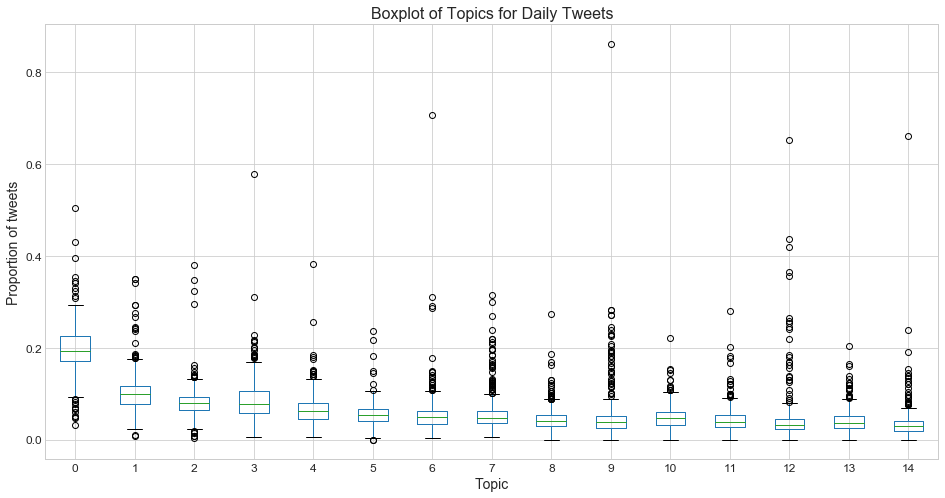

In [9]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(16, 8))
topics_daily.boxplot()
plt.xlabel('Topic', fontsize=14)
plt.ylabel('Proportion of tweets', fontsize=14)
plt.title('Boxplot of Topics for Daily Tweets', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=12)

fig.savefig('../visuals/tweets_boxplot.png')

plt.show()

In [13]:
print(topics_daily.idxmax())

0     2016-11-02
1     2016-02-29
2     2016-07-21
3     2016-11-23
4     2016-09-26
5     2016-10-05
6     2016-12-19
7     2015-12-16
8     2016-10-17
9     2016-11-08
10    2017-08-03
11    2017-06-23
12    2016-09-01
13    2016-03-22
14    2016-06-20
dtype: object
